In [22]:
import logging
from pathlib import Path

import bilby
import h5py
from matplotlib import pyplot as plt
import numpy as np

from typing import Dict, List, Tuple

import numpy as np
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters
from bilby.gw.source import lal_binary_black_hole
from bilby.gw.waveform_generator import WaveformGenerator

In [37]:
def generate_gw(
    sample_params: Dict[List, str],
    minimum_frequency: float,
    reference_frequency: float,
    sample_rate: float,
    waveform_duration: float,
    waveform_approximant: str,
):
    """Generate raw gravitational-wave signals, pre-interferometer projection.
    Args:
        sample_params:
            Dictionary of GW parameters where key is the parameter name
            and value is a list of the parameters
        minimum_frequency:
            Minimum_frequency for generating waveform; not to be confused with
            highpass filter frequency
        reference_frequency:
            Reference frequency for generating waveform
        sample_rate:
            Rate at which to sample time series
        waveform_duration:
            Duration of waveform
        waveform_approximant:
            Name of waveform approximant to use.
    Returns:
        An (n_samples, 2, waveform_size) array, containing both polarizations
        for each of the desired number of samples.
        The waveforms are shifted such that
        the coalescence time lies at the center of the sample
    """

    sample_params = [
        dict(zip(sample_params, col)) for col in zip(*sample_params.values())]

    n_samples = len(sample_params)

    waveform_generator = WaveformGenerator(
        duration=waveform_duration,
        sampling_frequency=sample_rate,
        frequency_domain_source_model=lal_binary_black_hole,
        parameter_conversion=convert_to_lal_binary_black_hole_parameters,
        waveform_arguments={
            "waveform_approximant": waveform_approximant,
            "reference_frequency": reference_frequency,
            "minimum_frequency": minimum_frequency,
        },
    )

    waveform_size = int(sample_rate * waveform_duration)

    num_pols = 2
    signals = np.zeros((n_samples, num_pols, waveform_size))

    for i, p in enumerate(sample_params):
        polarizations = waveform_generator.time_domain_strain(p)
        polarization_names = sorted(polarizations.keys())
        polarizations = np.stack(
            [polarizations[p] for p in polarization_names]
        )

        # center so that coalescence time is middle sample
        dt = waveform_duration / 2
        polarizations = np.roll(polarizations, int(dt * sample_rate), axis=-1)
        signals[i] = polarizations



    plt.figure()
    plt.xlim(7500, 8500)  # Set x-axis limits
    
    plt.plot(signals[1000][1],'r',label='H1 strain')
    plt.title('BBH Waveform Simulation')
    plt.savefig('BBH_Waveform_Simulation_expanded4.png')
    plt.show()
    plt.close()

    return signals


In [38]:
def generate_bbh_waveform(
    n_samples: int,
    reference_frequency: float,
    minimum_frequency: float,
    sample_rate: float,
    waveform_duration: float,
    waveform_approximant: str,
):
    """Simulates a set of raw BBH signals and saves them to an output file.
    Args:
        prior_file: prior file for bilby to sample from
        n_samples: number of signal to inject
        logdir: directory where log file will be written
        datadir: output directory to which signals will be written
        reference_frequency: reference frequency for waveform generation
        minimum_frequency: minimum_frequency for waveform generation
        sample_rate: rate at which to sample waveforms
        waveform_duration: length of injected waveforms
        waveform_approximant: which lalsimulation waveform approximant to use
        force_generation: if True, generate signals even if path already exists
        verbose: log verbosely
    Returns:
        path to h5 output file containing signals
    """


    # check if signal file already exists
    signal_file = "datadir//signals.h5"

    # sample gw parameters from prior distribution
    #priors = bilby.gw.prior.BBHPriorDict()
    priors = bilby.gw.prior.PriorDict(str(prior_file))
    sample_params = priors.sample(n_samples)


    signals = generate_gw(
        sample_params,
        minimum_frequency,
        reference_frequency,
        sample_rate,
        waveform_duration,
        waveform_approximant,
    )

    # Write params and similar to output file
    if np.isnan(signals).any():
        raise ValueError("The signals contain NaN values")

    with h5py.File(signal_file, "w") as f:
        # write signals attributes, snr, and signal parameters
        for k, v in sample_params.items():
            f.create_dataset(k, data=v)

        f.create_dataset("signals", data=signals)

        # write attributes
        f.attrs.update(
            {
                "size": n_samples,
                "sample_rate": sample_rate,
                "waveform_duration": waveform_duration,
                "waveform_approximant": waveform_approximant,
                "reference_frequency:": reference_frequency,
                "minimum_frequency": minimum_frequency,
            }
        )

    return signal_file

20:13 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


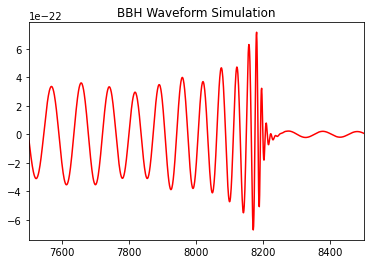

In [39]:
n_samples = 10000
waveform_duration = 8
sample_rate = 2048
ifos = ['H1', 'L1']

force_generation = False
kernel_length = 2
inference_sampling_rate = 16
minimum_frequency = 20 
reference_frequency = 50
prior_file = "./priors/nonspin_BBH.prior"
waveform_approximant = "IMRPhenomPv2"

signal_file = generate_bbh_waveform(
    n_samples,
    reference_frequency,
    minimum_frequency,
    sample_rate,
    waveform_duration,
    waveform_approximant
)